### Title

Using a K-NN Classification Model to Predict the Genre of a given Song based on Danceability and Energy


### Introduction


Today, listening to music has been more accessible than ever. Popular streaming platforms like Spotify make it easy for users to discover new music genres and receive recommendations aligned with their music preferences (Ignatius Moses Setiadi et al., 2020). Music recommendations play a crucial role in helping users find songs specifically tailored to their tastes, which often involves the process of classifying music genres via a variety of classifiers (Ignatius Moses Setiadi et al., 2020). The enjoyment of a song can depend on various factors, such as emotional impact, catchy melodies, or impactful lyrics (Khan et al., 2022). Additionally, audio features like loudness, tempo or energy can be used to classify a song’s genre, and are often used by music streaming platforms to recommend new songs to their users (Khan et al., 2022). 

Based on this information, the question we want to answer with our project is: “What is the genre of a given song based on its danceability and energy values?” This is a classification question, which uses one or more variables to predict the value of a categorical variable of interest. We will be using the K-nearest neighbors algorithm to predict the genre for our chosen song. KNN is used to predict the correct class for the test data by calculating the Euclidean distance between the test data and all the training points (Taunk et al., 2019). The test data is assigned to the class that corresponds to its K nearest neighbors, with ‘K’ being the number of neighbors that must be considered (Taunk et al., 2019). The best value of K depends on the dataset and is not always the largest value, because other undesired points may get included in the neighborhood and blur the classification boundaries (Taunk et al., 2019). The dataset we will be using is “Dataset of songs in Spotify'' from Kaggle. This dataset has 22 columns titled: danceability, energy, key, loudness, mode, speechless, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, time_signature, and song_name. The full list of genres includes Trap, Techno, Techhouse, Trance, Psytrance, Dark Trap, DnB (drums and bass), Hardstyle, Underground Rap, Trap Metal, Emo, Rap, RnB, Pop and Hiphop. We will be using danceability (from 0-0.99), energy (from 0-1) and genre in our project. 


### Preliminary exploratory data analysis

In [1]:
library(readr)
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::fil

In [2]:
urlfile="https://raw.githubusercontent.com/brandonzchen/GroupProjDSCI/main/genres_v2.csv"

mydata<-read_csv(url(urlfile))

Rows: 42305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): type, id, uri, track_href, analysis_url, genre, song_name, title
dbl (14): danceability, energy, key, loudness, mode, speechiness, acousticne...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
#This is the code for a summary of the information of the data

datainformation <- mydata |>
    select(danceability, energy, genre) |>
    filter(genre == "Emo" | genre == "hardstyle" | genre == "Hiphop") |>
    group_by(genre) |>
    summarise(count = n(), mean_energy = mean(energy), mean_danceability = mean(danceability))

datainformation

genre     count mean_energy mean_danceability
1 Emo       1680  0.7611750   0.4936988        
2 Hiphop    3028  0.6544179   0.6989818        
3 hardstyle 2936  0.8962384   0.4780270

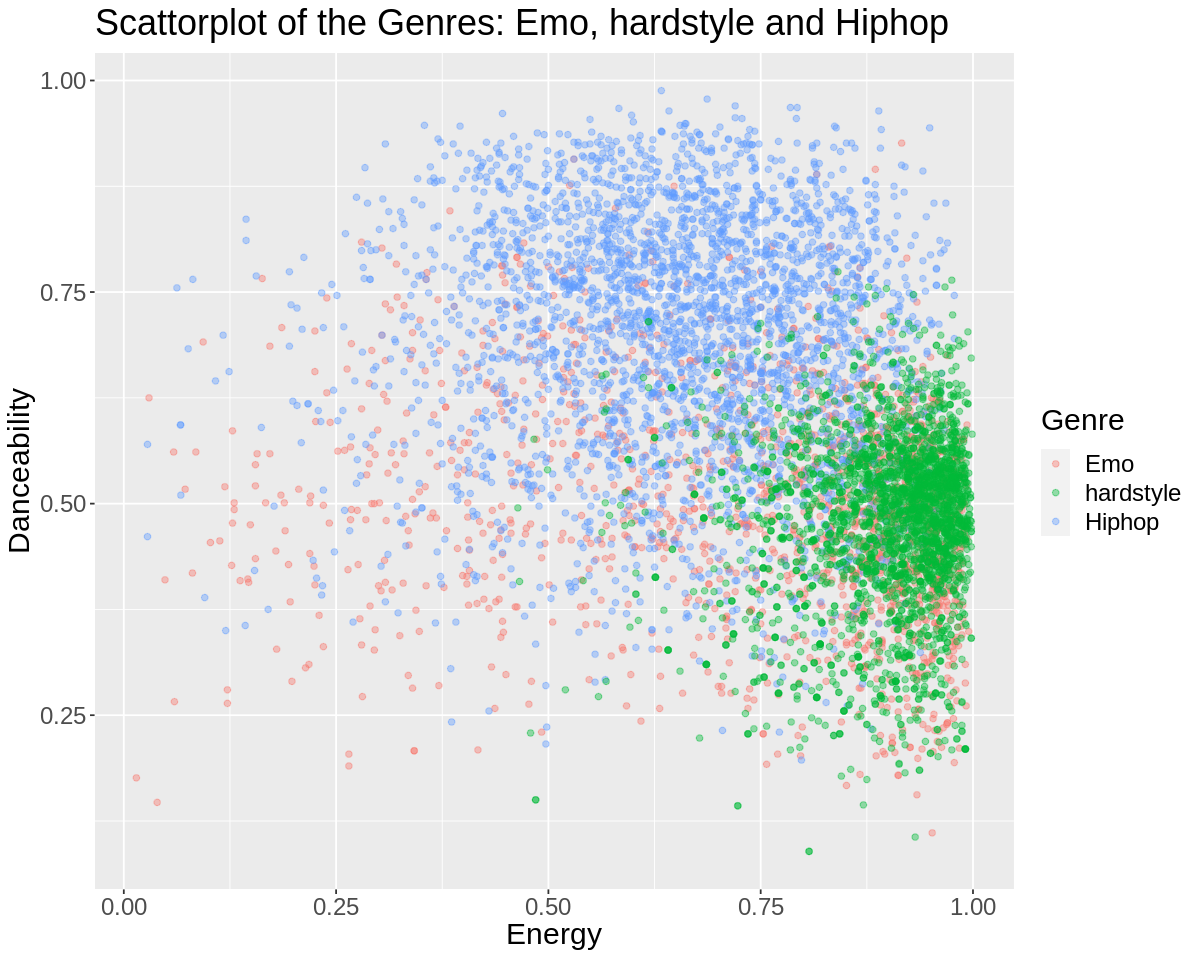

In [39]:
song_data <- mydata |>
    select(danceability, energy, genre) |>
    filter(genre == "Emo" | genre == "hardstyle" | genre == "Hiphop")

genre_plot <- song_data |>
    ggplot(aes(x = energy, y = danceability)) + 
        geom_point(alpha = 0.4, aes(colour = genre)) +
        ggtitle("Scattorplot of the Genres: Emo, hardstyle and Hiphop") +
        xlab("Energy") +
        ylab("Danceability") +
        labs(colour = "Genre") +
        theme(text = element_text(size = 18))
options(repr.plot.width = 10, repr.plot.height = 8)
genre_plot

EVERYTHING BELOW IS THE NEWLY ADDED CODE !!!!!!!!!!!!!

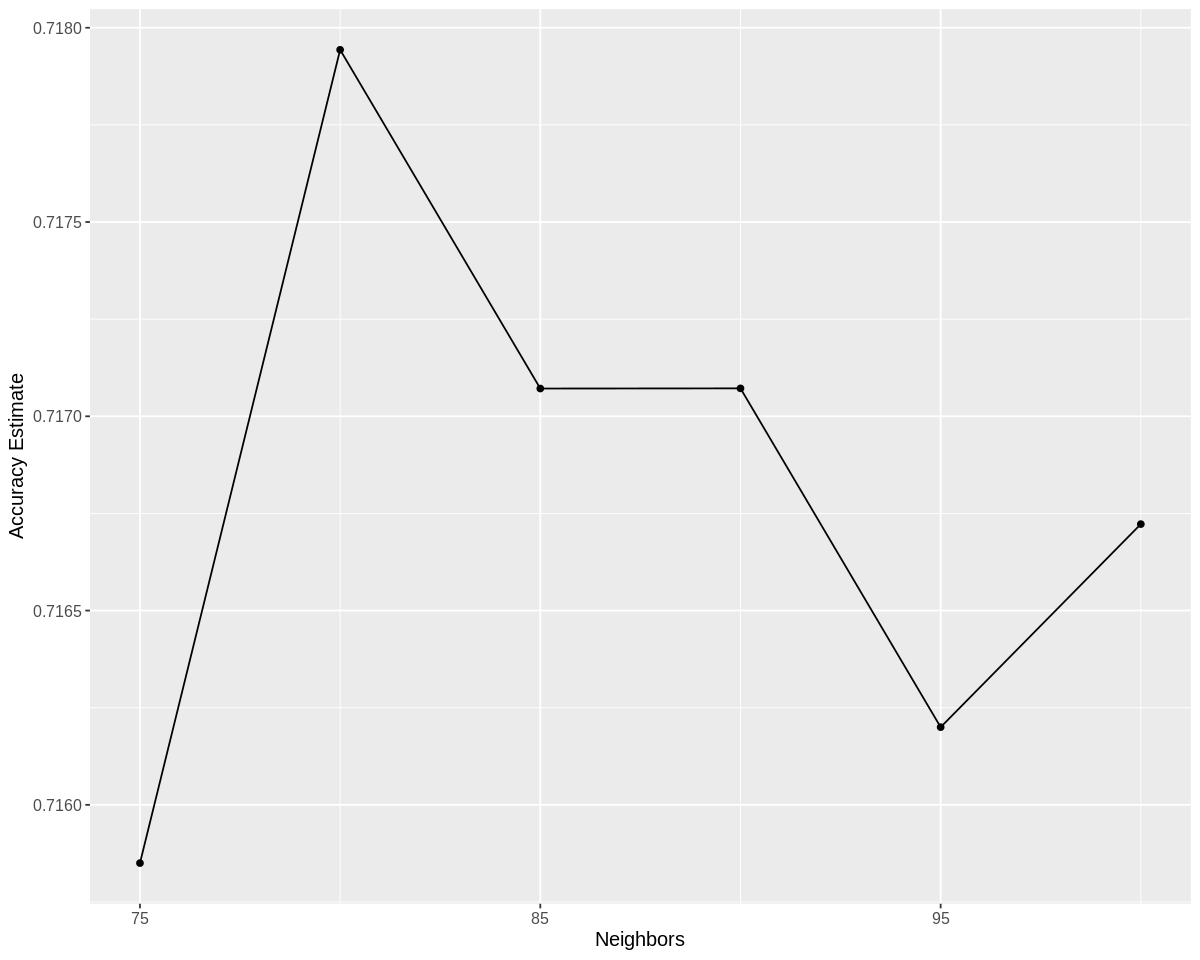

In [7]:
set.seed(2023)

song_split <- initial_split(song_data, prop = 0.75, strata = genre)
song_train <- training(song_split)
song_test <- testing(song_split)

knn_recipe <- recipe(genre ~ energy + danceability, data = song_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_vfold <- vfold_cv(song_train, v = 5, strata = genre)

k_vals <- tibble(neighbors = seq(from = 75, to = 100, by = 5))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = knn_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(75, 100, by = 10))
cross_val_plot

In [41]:
set.seed(9999)

song_data <- mydata |>
    select(danceability, energy, genre) |>
    filter(genre == "Emo" | genre == "hardstyle" | genre == "Hiphop")

song_data$genre <- as.factor(song_data$genre)

song_split <- initial_split(song_data, prop = 0.75, strata = genre)
song_train <- training(song_split)
song_test <- testing(song_split)

knn_recipe <- recipe(genre ~ energy + danceability, data = song_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


song_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 80) |>
    set_engine("kknn") |>
    set_mode("classification")

song_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(song_spec) |>
    fit(data = song_train)

song_test_predictions <- predict(song_fit, song_test) |>
    bind_cols(song_test) |>
    metrics(truth = genre, estimate = .pred_class) |>
    filter(.metric == "accuracy")
song_test_predictions

.metric  .estimator .estimate
1 accuracy multiclass 0.7174254

In [48]:
song_recipe <- recipe(genre ~ energy + danceability, data = song_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

song_fit_real <- workflow() |>
    add_recipe(song_recipe) |>
    add_model(song_spec) |>
    fit(data = song_data)

new_song_1 <- tibble(energy = 0.29, danceability = 0.56)
new_song_2 <- tibble(energy = 0.889, danceability = 0.628)
new_song_3 <- tibble(energy = 0.84, danceability = 0.75)

new_song_1_predicted <- predict(song_fit_real, new_song_1)
new_song_2_predicted <- predict(song_fit_real, new_song_2)
new_song_3_predicted <- predict(song_fit_real, new_song_3)

new_song_1_predicted
new_song_2_predicted
new_song_3_predicted

.pred_class
1 Emo

.pred_class
1 hardstyle

.pred_class
1 Hiphop

### Methods

Using the “Dataset of songs in Spotify'' dataset, we will be conducting a K-NN classification on specific songs within the dataset to predict their genre. This will be done by specifically using “danceability” and “energy” as the predictor variables and “genre” as the response variable. We will first filter our dataset to only include danceability, energy and genre as the only 3 variables, tidy the data, and further shrink the data by selecting for the 3 genres: Emo, hardstyle and Hiphop. We will then set aside specific observations from the data which our classifier will be predicting the genre for. We will then begin building, tuning, and evaluating our K-NN classification model. This will include dividing the data up into a training set and testing set, using the training set to build and tune our model through cross-validation and evaluating our chosen K value using the testing set. Finally, we will then use this classification model to predict the selected songs we initially set aside and graph the data using a scatterplot. This scatterplot will include the energy variable in the x-axis, danceability in the y-axis, color coding for each of the 3 genres, as well as a different color indicator for the observations we are predicting for.

### Expected outcomes and significance

What do you expect to find?
- Correlations between genre and either energy or danceability. For example, we might find that hiphop may have higher danceability scores while hardstyle may have lower danceability scores.
- Correlations between genre and both energy and danceability. For example, we expect to find that songs with relatively higher danceability and energy are more likely to be hiphop songs while lower danceability and energy scores are more likely to be emo songs.

What impact could such findings have?
- These findings can improve the music that is recommended to users in music apps. By exploring the user's preference for danceability and energy in music, the app can better recommend more personalized music based on these trends.
- These findings can help users find music for different occasions. Users can use this information to select the appropriate music or genre for different occasions.

What future questions could this lead to?
- This project can lead to thinking about how to make a more accurate genre predicting model. We can consider and incorporate more features of music that influences genre to make a more comprehensive and accurate model.
- This project can also lead us to be curious about other trends with these variables, such as how genres have evolved over time in terms of danceability and energy.

### References



Dataset of songs in Spotify. (n.d.). Retrieved December 7, 2023, from https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotifyhttps://doi.org/10.1109/ICCS45141.2019.9065747

Ignatius Moses Setiadi, D. R., Satriya Rahardwika, D., Rachmawanto, E. H., Atika Sari, C., Irawan, C., Kusumaningrum, D. P., Nuri, & Trusthi, S. L. (2020). Comparison of SVM, KNN, and NB Classifier for Genre Music Classification based on Metadata. 2020 International Seminar on Application for Technology of Information and Communication (iSemantic), 12–16. https://doi.org/10.1109/iSemantic50169.2020.9234199

Khan, F., Tarimer, I., Alwageed, H. S., Karadağ, B. C., Fayaz, M., Abdusalomov, A. B., & Cho, Y.-I. (2022). Effect of Feature Selection on the Accuracy of Music Popularity Classification Using Machine Learning Algorithms. Electronics, 11(21), Article 21. https://doi.org/10.3390/electronics11213518

Taunk, K., De, S., Verma, S., & Swetapadma, A. (2019). A Brief Review of Nearest Neighbor Algorithm for Learning and Classification. 2019 International Conference on Intelligent Computing and Control Systems (ICCS), 1255–1260. https://doi.org/10.1109/ICCS45141.2019.9065747
